In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def create_spectrogram(file_path, save_path):
    y, sr = librosa.load(file_path, sr=None)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(S_db, sr=sr,x_axis=None,y_axis=None, cmap='magma')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

KeyboardInterrupt: 

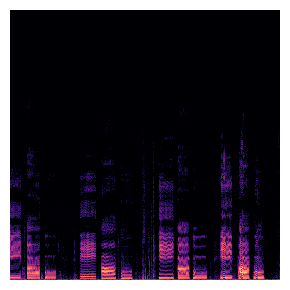

In [3]:
def spectrograms(base_dir="/Users/manyasharma/FINAL_PROJECT_(POLYP)", output_dir="/Users/manyasharma/FINAL_PROJECT_(POLYP)/spectograms1"):
    os.makedirs(output_dir, exist_ok=True)
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if not os.path.isdir(label_path):
            continue
        save_class_dir = os.path.join(output_dir, label)
        os.makedirs(save_class_dir, exist_ok=True)

        for i, file in enumerate(os.listdir(label_path)):
            if file.endswith('.wav'):
                file_path = os.path.join(label_path, file)
                save_path = os.path.join(save_class_dir, f"{label}_{i}.png")
                create_spectrogram(file_path, save_path)

spectrograms()

In [4]:
!pip install torch torchvision scikit-learn matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

In [5]:
import os

base_path = "/Users/manyasharma/FINAL_PROJECT_(POLYP)/spectograms1"

print("Contents of spectograms1:")
for item in os.listdir(base_path):
    item_path = os.path.join(base_path, item)
    print(f"- {item} (Dir: {os.path.isdir(item_path)})")
    if os.path.isdir(item_path):
        print(f"  Files in {item}: {os.listdir(item_path)}")

Contents of spectograms1:
- Healthy (Dir: True)
  Files in Healthy: ['Healthy_158.png', 'Healthy_170.png', 'Healthy_164.png', 'Healthy_16.png', 'Healthy_206.png', 'Healthy_212.png', 'Healthy_2.png', 'Healthy_3.png', 'Healthy_213.png', 'Healthy_207.png', 'Healthy_17.png', 'Healthy_165.png', 'Healthy_171.png', 'Healthy_159.png', 'Healthy_167.png', 'Healthy_173.png', 'Healthy_198.png', 'Healthy_239.png', 'Healthy_15.png', 'Healthy_211.png', 'Healthy_205.png', 'Healthy_29.png', 'Healthy_1.png', 'Healthy_0.png', 'Healthy_204.png', 'Healthy_28.png', 'Healthy_210.png', 'Healthy_238.png', 'Healthy_14.png', 'Healthy_199.png', 'Healthy_172.png', 'Healthy_166.png', 'Healthy_162.png', 'Healthy_176.png', 'Healthy_189.png', 'Healthy_214.png', 'Healthy_38.png', 'Healthy_200.png', 'Healthy_228.png', 'Healthy_10.png', 'Healthy_4.png', 'Healthy_5.png', 'Healthy_11.png', 'Healthy_229.png', 'Healthy_201.png', 'Healthy_215.png', 'Healthy_39.png', 'Healthy_188.png', 'Healthy_177.png', 'Healthy_163.png', 'He

In [6]:
valid_exts = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
for folder in ['Healthy', 'Polyp']:
    full_path = os.path.join(base_path, folder)
    for file in os.listdir(full_path):
        if not any(file.lower().endswith(ext) for ext in valid_exts):
            print(f"[!] Invalid image extension in {folder}: {file}")

[!] Invalid image extension in Healthy: .ipynb_checkpoints


In [7]:
import shutil
shutil.rmtree("/Users/manyasharma/FINAL_PROJECT_(POLYP)/spectograms1/.ipynb_checkpoints", ignore_errors=True)

In [8]:
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(
    root=base_path,
    transform=transform
)

print("Classes:", train_data.class_to_idx)

Classes: {'Healthy': 0, 'Polyp': 1}


In [9]:
targets = train_data.targets
train_idx, val_idx = train_test_split(
    list(range(len(targets))),
    test_size=0.2,
    stratify=targets,
    random_state=42
)
train_dataset = Subset(train_data, train_idx)
val_dataset = Subset(train_data, val_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 25 * 25, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1, Loss: 19.6332
Epoch 2, Loss: 19.1852
Epoch 3, Loss: 17.6381
Epoch 4, Loss: 17.0411
Epoch 5, Loss: 15.0414
Epoch 6, Loss: 16.7400
Epoch 7, Loss: 14.8119
Epoch 8, Loss: 15.0884
Epoch 9, Loss: 13.8559
Epoch 10, Loss: 13.9650
Epoch 11, Loss: 11.8399
Epoch 12, Loss: 11.5493
Epoch 13, Loss: 10.5825
Epoch 14, Loss: 9.9286
Epoch 15, Loss: 8.4406
Epoch 16, Loss: 7.7641
Epoch 17, Loss: 7.1616
Epoch 18, Loss: 6.3387
Epoch 19, Loss: 7.2184
Epoch 20, Loss: 5.4286
Epoch 21, Loss: 4.2013
Epoch 22, Loss: 4.2206
Epoch 23, Loss: 3.2561
Epoch 24, Loss: 3.3354
Epoch 25, Loss: 3.2154
Epoch 26, Loss: 4.3810
Epoch 27, Loss: 2.8864
Epoch 28, Loss: 1.9049
Epoch 29, Loss: 1.6538
Epoch 30, Loss: 1.3956
Epoch 31, Loss: 0.9122
Epoch 32, Loss: 1.1278
Epoch 33, Loss: 0.9499
Epoch 34, Loss: 0.9099
Epoch 35, Loss: 0.9594
Epoch 36, Loss: 0.8595
Epoch 37, Loss: 0.6883
Epoch 38, Loss: 0.7734
Epoch 39, Loss: 1.0869
Epoch 40, Loss: 0.6801
Epoch 41, Loss: 0.5457
Epoch 42, Loss: 0.9863
Epoch 43, Loss: 0.4415
Epoch 4

Accuracy: 83.93%


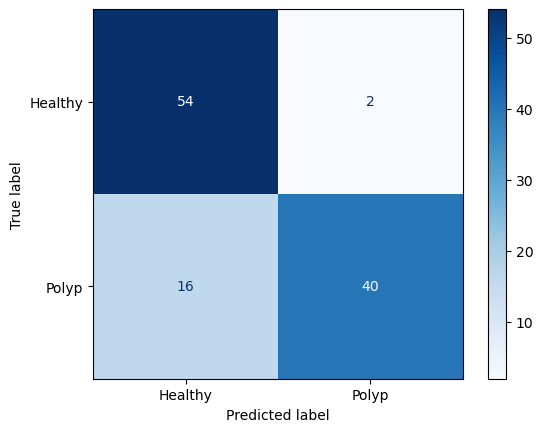

              precision    recall  f1-score   support

     Healthy       0.77      0.96      0.86        56
       Polyp       0.95      0.71      0.82        56

    accuracy                           0.84       112
   macro avg       0.86      0.84      0.84       112
weighted avg       0.86      0.84      0.84       112



In [13]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = (outputs.cpu().numpy() > 0.5).astype(int)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted)

y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred).flatten()

accuracy = np.mean(y_true == y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Healthy", "Polyp"])
disp.plot(cmap = "Blues")
plt.show()

print(classification_report(y_true, y_pred, target_names=train_data.classes))